In [12]:
import torch
import yaml
import glob
import numpy as np
import matplotlib.pyplot as plt

from credit.vit2d import ViT2D
from credit.data import ERA5Dataset, ToTensor, NormalizeState, NormalizeTendency, DistributedSequentialDataset
from torchvision import transforms
from credit.loss import TotalLoss2D
import gc

from collections import defaultdict
from credit.metrics import anomaly_correlation_coefficient as ACC

In [2]:
#save_loc = '/glade/work/schreck/repos/global/miles-credit/results/vit_phase1' #conf['save_loc']
save_loc = '/glade/work/schreck/repos/global/MLWPS/results/sanity_check_current_codebase'
#save_loc = '../results/casper/1214/vit2d/' #conf['save_loc']
#save_loc = '../results/derecho/1215/vit_ddp/' #conf['save_loc']
#save_loc = '../results/weights/

device = "cuda:0"
config_file = f"{save_loc}/model.yml"

In [3]:
with open(config_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
history_len = 23
forecast_len = 24
time_step = 1
    
# datasets (zarr reader) 
all_ERA_files = sorted(glob.glob(conf["data"]["save_loc"]))
    
# Specify the years for each set
test_years = [str(year) for year in range(2018, 2022)] # same as graphcast -- always hold out

# Filter the files for each set
test_files = [file for file in all_ERA_files if any(year in file for year in test_years)]

transform = transforms.Compose([
    NormalizeState(conf["data"]["mean_path"],conf["data"]["std_path"]),
    ToTensor(history_len=history_len, forecast_len=forecast_len)
])

test_dataset = DistributedSequentialDataset(
    filenames=test_files,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=time_step,
    transform=transform,
    rank=0,
    world_size=1,
    shuffle=True
)

# setup the dataloder for this process
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=0,
    drop_last=True)

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [5]:
model = ViT2D.load_model(conf).to(device)

model.eval()

ViT2D(
  (transformer_encoder): LRTransformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=24576, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=8192, out_features=1024, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): GELU(approximate='none')
            (3): Dropout(p=0.0, inplace=False)
            (4): Linear(in_features=1024, out_features=1024, bias=True)
            (5): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
  )
  (transformer_de

In [13]:
conf['loss']['use_latitude_weights'] = True

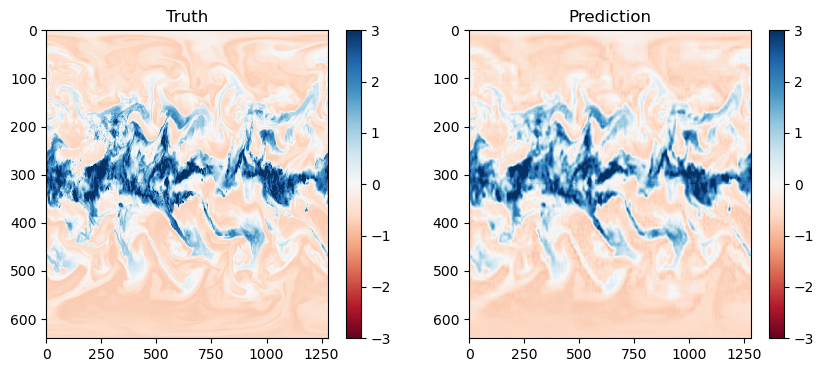

tensor([3203]) tensor([0]) tensor(0.0093, device='cuda:0') 0.9933045506477356


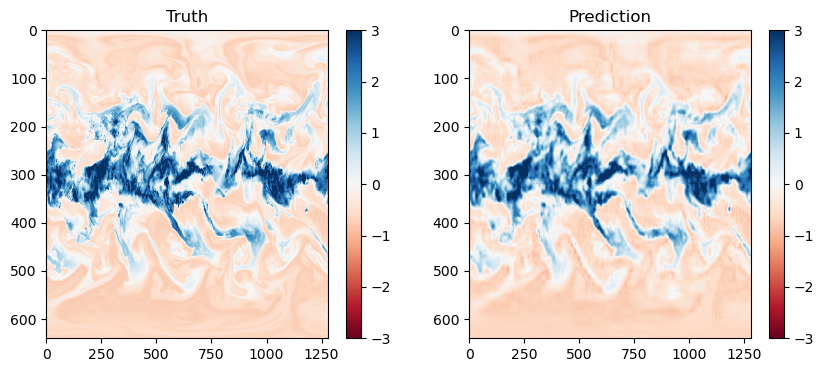

tensor([3203]) tensor([1]) tensor(0.0123, device='cuda:0') 0.9908698797225952


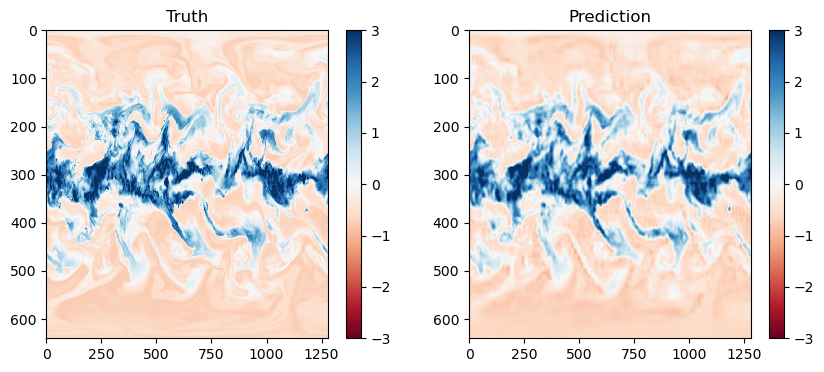

tensor([3203]) tensor([2]) tensor(0.0160, device='cuda:0') 0.9878714680671692


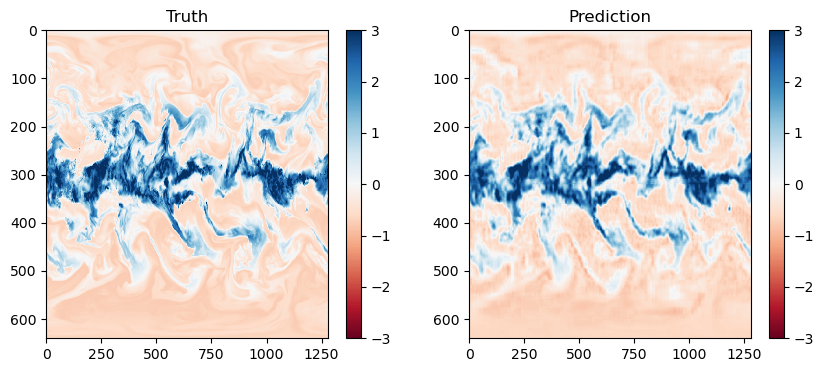

tensor([3203]) tensor([3]) tensor(0.0202, device='cuda:0') 0.9844723343849182


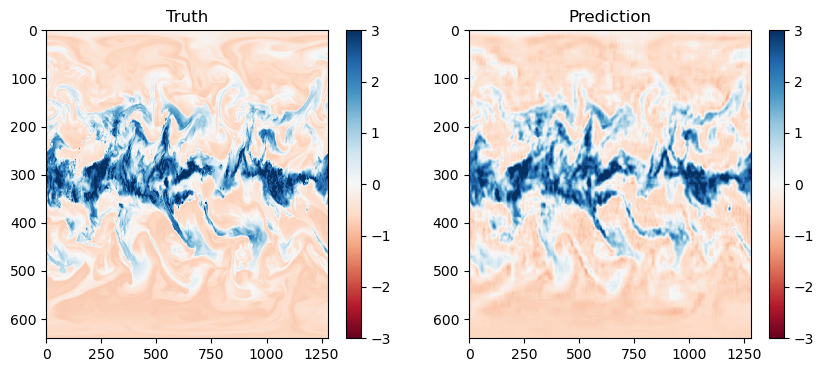

tensor([3203]) tensor([4]) tensor(0.0246, device='cuda:0') 0.9808709025382996


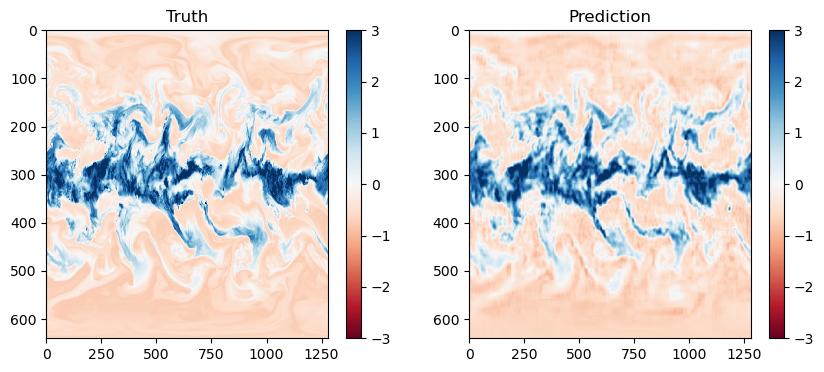

tensor([3203]) tensor([5]) tensor(0.0293, device='cuda:0') 0.9771667122840881


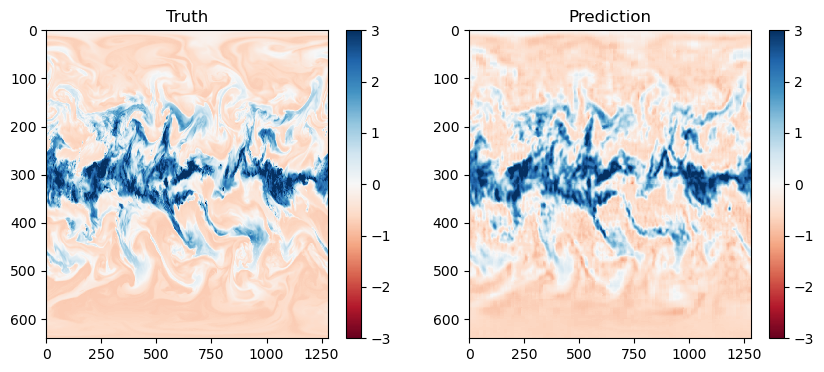

tensor([3203]) tensor([6]) tensor(0.0339, device='cuda:0') 0.9734646081924438


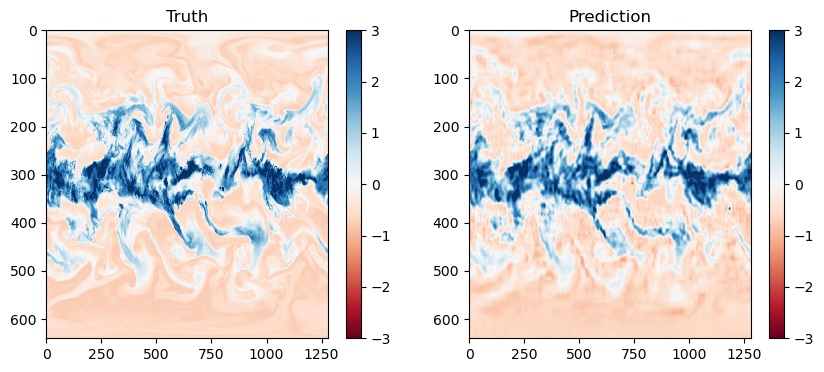

tensor([3203]) tensor([7]) tensor(0.0385, device='cuda:0') 0.969865620136261


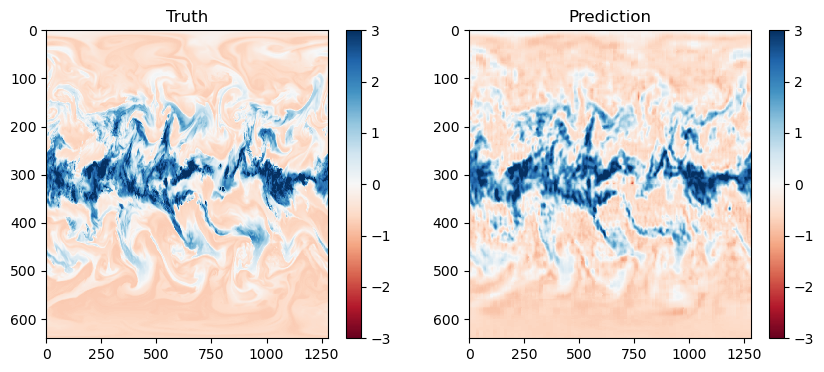

tensor([3203]) tensor([8]) tensor(0.0433, device='cuda:0') 0.9661646485328674


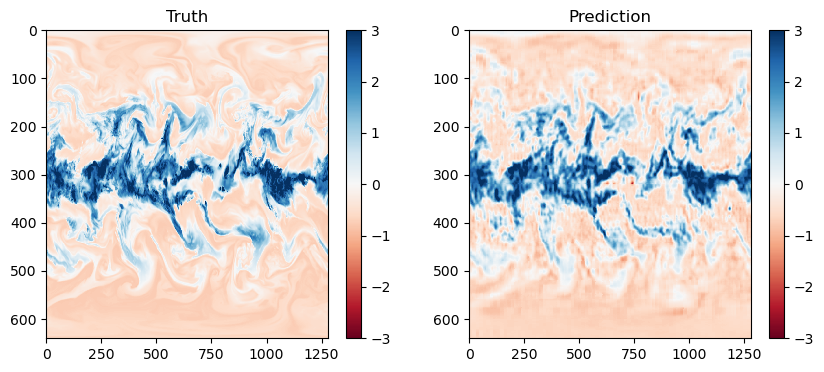

tensor([3203]) tensor([9]) tensor(0.0481, device='cuda:0') 0.9624198079109192


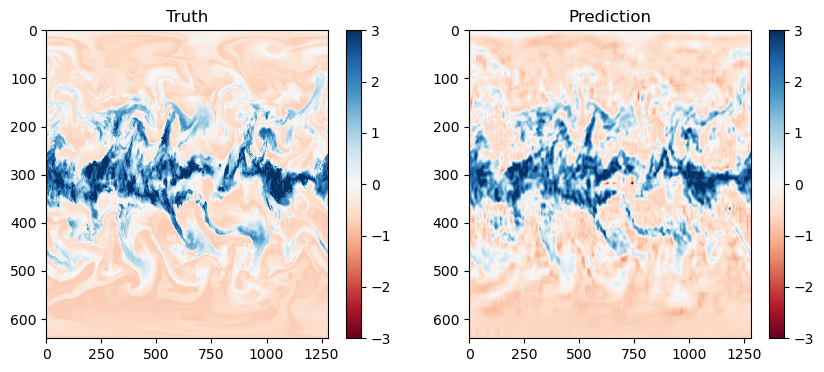

tensor([3203]) tensor([10]) tensor(0.0552, device='cuda:0') 0.9568547606468201


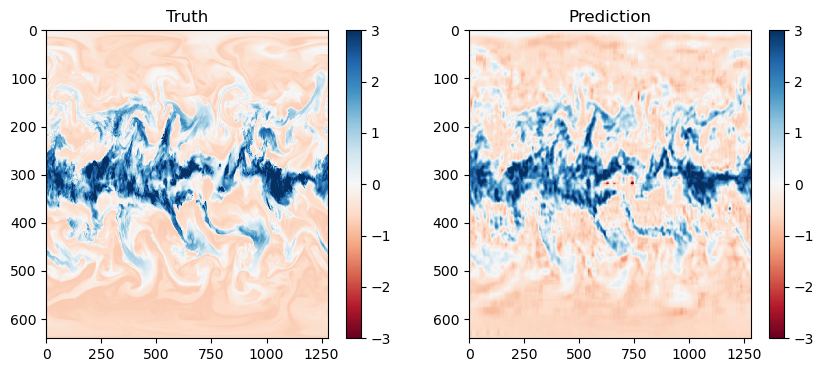

tensor([3203]) tensor([11]) tensor(0.0601, device='cuda:0') 0.9528751373291016


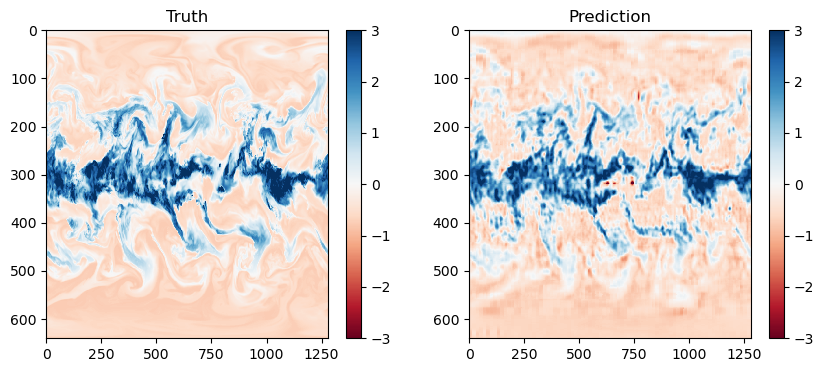

tensor([3203]) tensor([12]) tensor(0.0652, device='cuda:0') 0.9486966729164124


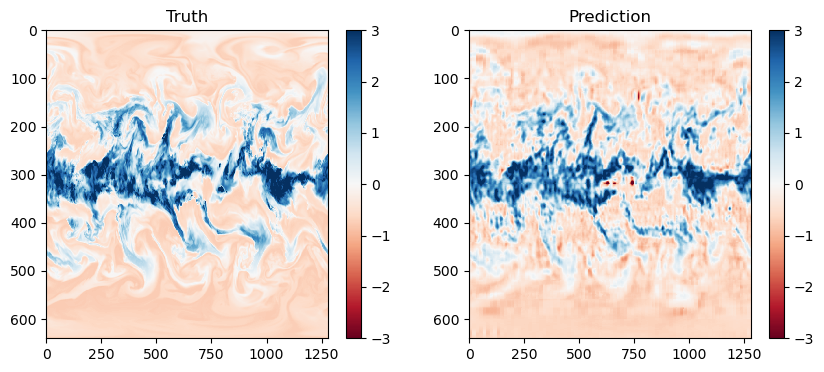

tensor([3203]) tensor([13]) tensor(0.0706, device='cuda:0') 0.9442592859268188


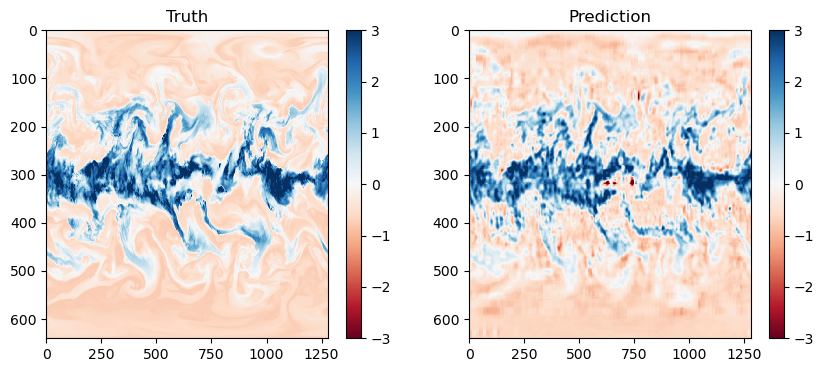

tensor([3203]) tensor([14]) tensor(0.0763, device='cuda:0') 0.9395416975021362


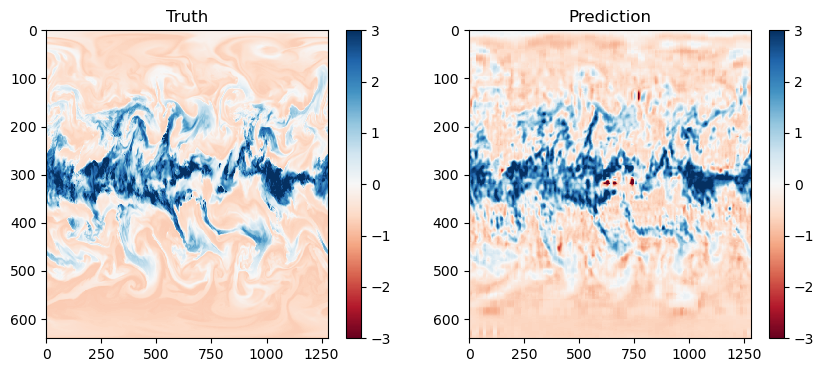

tensor([3203]) tensor([15]) tensor(0.0826, device='cuda:0') 0.9345331192016602


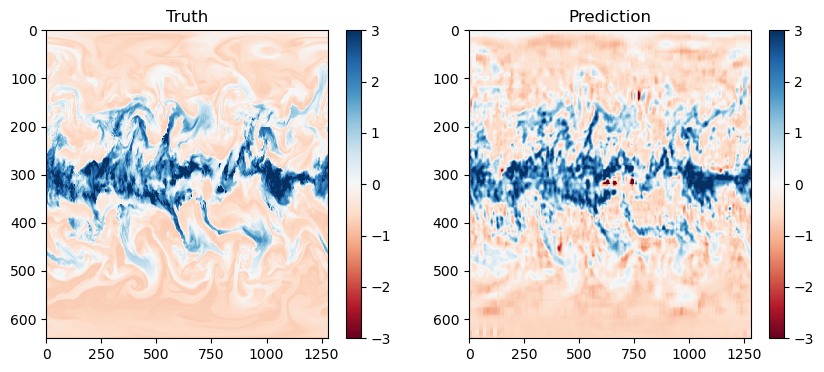

tensor([3203]) tensor([16]) tensor(0.0895, device='cuda:0') 0.9289671182632446


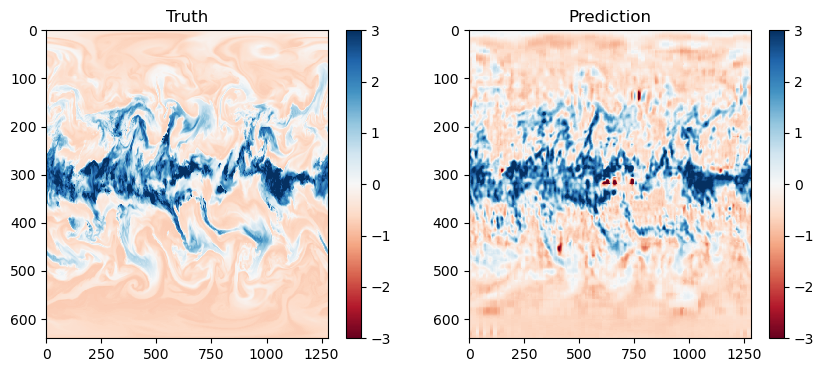

tensor([3203]) tensor([17]) tensor(0.0970, device='cuda:0') 0.9229403734207153


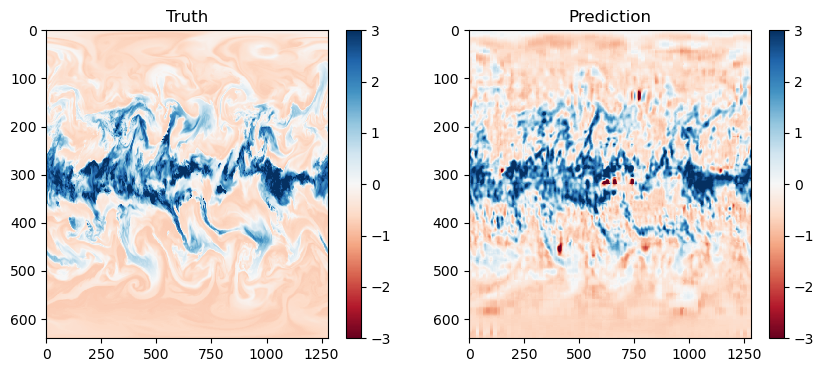

tensor([3203]) tensor([18]) tensor(0.1050, device='cuda:0') 0.9165863394737244


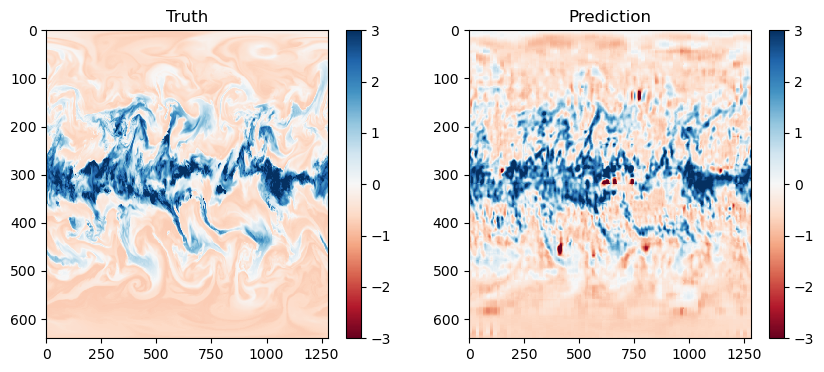

tensor([3203]) tensor([19]) tensor(0.1136, device='cuda:0') 0.9098690748214722


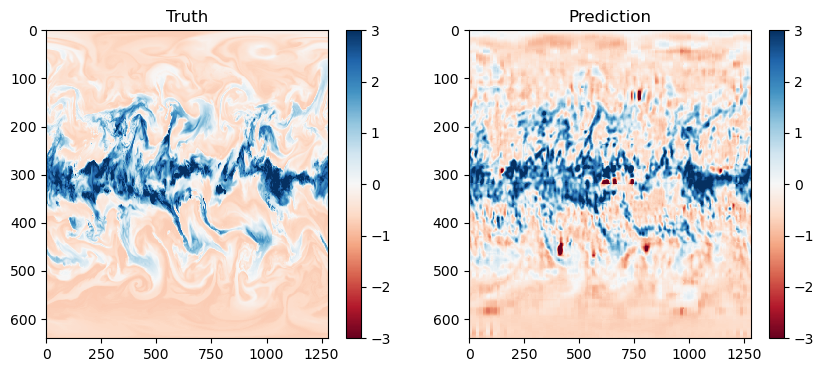

tensor([3203]) tensor([20]) tensor(0.1227, device='cuda:0') 0.9028961062431335


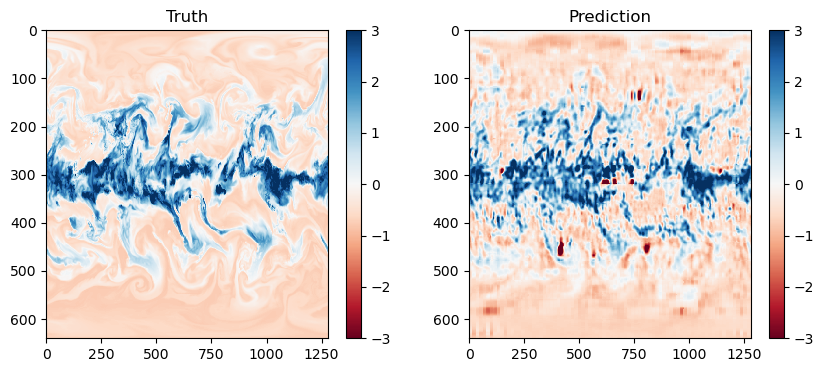

tensor([3203]) tensor([21]) tensor(0.1327, device='cuda:0') 0.8955985307693481


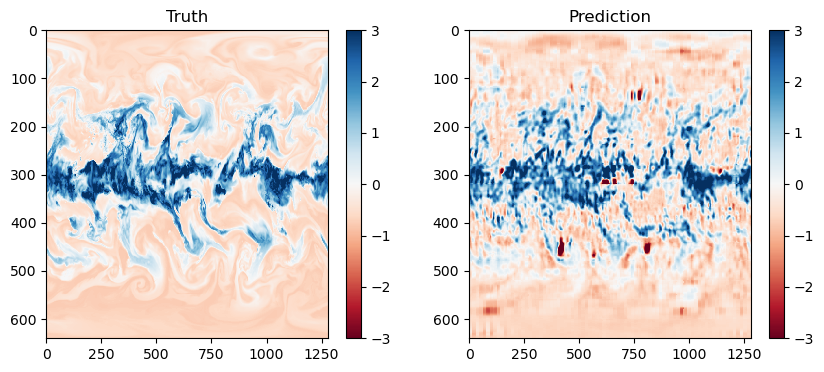

tensor([3203]) tensor([22]) tensor(0.1450, device='cuda:0') 0.8864293098449707


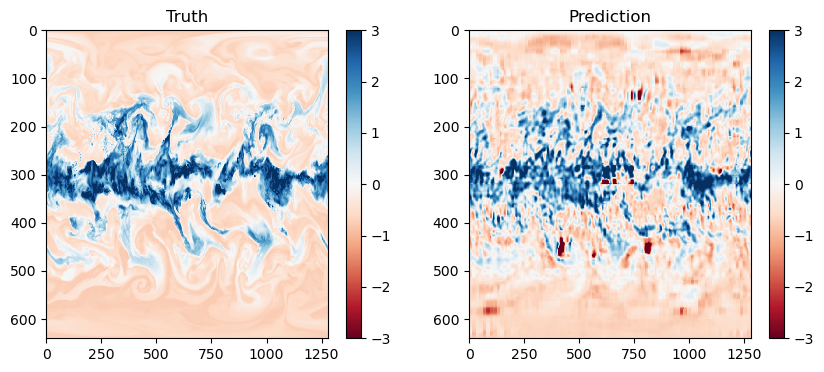

tensor([3203]) tensor([23]) tensor(0.1568, device='cuda:0') 0.8782381415367126


In [30]:
results = defaultdict(list)

with torch.no_grad(): 

    true_arrays = []  # List to store true arrays
    pred_arrays = []  # List to store predicted arrays
    
    #loss_fn = torch.nn.L1Loss()
    loss_fn = TotalLoss2D(conf)

    loss = 0.0
    for batch in test_loader:

        if batch["forecast_hour"].item() == 0:
            # Initialize x and x_surf with the first time step
            x_atmo = batch["x"].squeeze(1)
            x_surf = batch["x_surf"].squeeze(1)
            x = model.concat_and_reshape(x_atmo, x_surf).to(device)

        y_atmo = batch["y"].squeeze(1)
        y_surf = batch["y_surf"].squeeze(1)
        y = model.concat_and_reshape(y_atmo, y_surf).to(device)
        
        # The model's output y_pred becomes the new x for the next time step
        y_pred = model(x)
        x = y_pred.detach()

        mae = loss_fn(y, y_pred)
        loss += mae

        true_arrays.append(y[0, 66, :, :].to('cpu').numpy())
        pred_arrays.append(y_pred[0, 66, :, :].to('cpu').numpy())

        # Plotting y
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.pcolor(y[0, 66, :, :].to('cpu').numpy(), cmap='RdBu', vmin=-3, vmax=3)
        plt.colorbar()
        plt.gca().invert_yaxis()
        #plt.title(f'Forecast hour {data["forecast_hour"].item()}')
        plt.title('Truth')

        # Plotting y_pred
        plt.subplot(1, 2, 2)
        plt.pcolor(y_pred[0, 66, :, :].to('cpu').numpy(), cmap='RdBu', vmin=-3, vmax=3)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title('Prediction')

        plt.show()

        results["forecast_hour"].append(batch["forecast_hour"].item())
        results["mae"].append(mae.item())
        results["acc"].append(ACC(y, y_pred))

        print(batch["index"], batch["forecast_hour"], mae, results["acc"][-1])

        del y_pred, y
        # Explicitly release GPU memory
        torch.cuda.empty_cache()
        gc.collect()

        if batch["forecast_hour"].item() == history_len:
            break

# Convert the lists to NumPy arrays
true_arrays = np.array(true_arrays)
pred_arrays = np.array(pred_arrays)

# Save NumPy arrays to disk
np.save('true_arrays.npy', true_arrays)
np.save('pred_arrays.npy', pred_arrays)

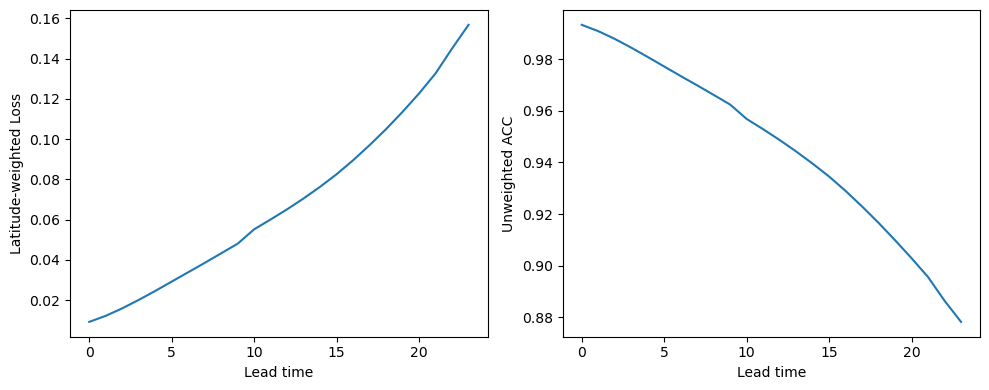

In [31]:
import matplotlib.pyplot as plt

# Assuming you have already created the 'results' DataFrame
plt.figure(figsize=(10, 4))

# Create a subplot with 1 row and 2 columns
plt.subplot(1, 2, 1)  # First column
plt.plot(results['forecast_hour'], results['mae'])
plt.xlabel("Lead time")
plt.ylabel("Latitude-weighted Loss")

plt.subplot(1, 2, 2)  # Second column
plt.plot(results['forecast_hour'], results['acc'])
plt.xlabel("Lead time")
plt.ylabel("Unweighted ACC")

plt.tight_layout()
plt.show()